In [3]:
'''python -m venv venv
venv\Scripts\activate
Create a virtual environment named 'venv' in the current directory
Activate the virtual environment (Windows only)'''
%pip install pandas numpy scikit-learn matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [5]:
CURRENT_DIR = "current"
PAST_DIR = "past"
SHEET_NAME = "Data Sheet"
FEATURES = ["Sales", "Net profit", "Reserves", "Borrowings"]
YEARS_BACK = 8
PREDICT_YEARS = 2
RANDOM_STATE = 42

In [6]:
current_file = [f for f in os.listdir(CURRENT_DIR) if f.endswith(".xlsx")]
current_path = os.path.join(CURRENT_DIR, current_file[0])


filepath=[]
company_names = []
for filename in os.listdir(PAST_DIR):
    if filename.endswith(".xlsx"):
        path = os.path.join(PAST_DIR, filename)
        filepath.append(path)
        company_names.append(os.path.splitext(filename)[0])





In [7]:
def extract_features(file_path):
    try:
        df = pd.read_excel(file_path, sheet_name=SHEET_NAME, header=None)
    except Exception as e:
        print(f"[ERROR] Couldn't read {file_path}: {e}")
        return {}
    features_data = {}
    for feature in FEATURES:
        row = df[df[0].astype(str).str.strip().str.lower() == feature.lower()]
        if not row.empty:
            values = pd.to_numeric(row.values[0][1:], errors='coerce')
            values = values[~np.isnan(values)]
            features_data[feature] = values.tolist()
        else:
            print(f"[WARN] '{feature}' not found in {os.path.basename(file_path)}")
            features_data[feature] = []
            print(features_data)
    return features_data


In [8]:
def predict_next_2_years(values):
    if len(values) < 2:
        return [0, 0]
    x = np.arange(len(values)).reshape(-1, 1)
    y = np.array(values)
    model = LinearRegression()
    model.fit(x, y)
    return model.predict(np.array([[len(values)], [len(values) + 1]])).tolist()

In [9]:
def build_feature_vector(features_dict, include_pred=False, expected_years=YEARS_BACK):
    vector = []
    for key in FEATURES:
        values = features_dict.get(key, [])[-expected_years:]
        values = [0] * (expected_years - len(values)) + values
        if include_pred:
            values += predict_next_2_years(values)
        vector.extend(values)
    return vector

In [10]:
def auto_label(features_dict):
    sales = features_dict.get("Sales", [])
    profit = features_dict.get("Net profit", [])
    reserves = features_dict.get("Reserves", [])
    borrowings = features_dict.get("Borrowings", [])

    def average_growth(values):
        if len(values) < 2:
            return 0
        diffs = [values[i+1] - values[i] for i in range(len(values)-1)]
        avg_growth = np.mean(diffs) / max(abs(values[0]), 1)  
        return avg_growth * 100

   
    growth_sales = average_growth(sales)
    growth_profit = average_growth(profit)
    growth_reserves = average_growth(reserves)
    growth_borrowings = average_growth(borrowings)

    
    score = (0.4 * growth_sales + 0.4 * growth_profit +
             0.1 * growth_reserves - 0.1 * growth_borrowings)  # 


    if score > 50:
        return "Excellent"
    elif score > 20:
        return "Good"
    elif score > 0:
        return "Average"
    else:
        return "Bad"


In [11]:
past_vectors, labels, past_names = [], [], []

for idx, filename in enumerate(filepath):

    feats = extract_features(filename)

    vec = build_feature_vector(feats, include_pred=True)

    if any(v != 0 for v in vec):

        past_vectors.append(vec)

        labels.append(auto_label(feats))

        past_names.append(os.path.splitext(os.path.basename(filename))[0])

In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(past_vectors)
clf = RandomForestClassifier(random_state=RANDOM_STATE)
clf.fit(X_train, labels)
print("✅ Past data processed. Model trained.")


current_features = extract_features(current_path)
predictions = {}
print("\n📈 Predicted values for next 2 years:")
for key in FEATURES:
    past = current_features.get(key, [])[-YEARS_BACK:]
    preds = predict_next_2_years(past)
    print(f"  ➤ {key}: {round(preds[0], 2)}, {round(preds[1], 2)}")
    predictions[key] = preds
    current_features[key] += preds

✅ Past data processed. Model trained.

📈 Predicted values for next 2 years:
  ➤ Sales: 431422.3, 455002.72
  ➤ Net profit: 26238.09, 31934.27
  ➤ Reserves: 80791.31, 83217.18
  ➤ Borrowings: 110669.13, 109667.53


In [13]:
vector_current = build_feature_vector(current_features, include_pred=True)
X_current = scaler.transform([vector_current])
pred_class = clf.predict(X_current)[0]
probs = clf.predict_proba(X_current)[0]
print("\n🧠 Investment Classification Result:")
print(f"  ✅ Predicted Category: {pred_class}")
print("  🔢 Confidence Scores:")
for label, prob in sorted(dict(zip(clf.classes_, probs)).items(), key=lambda x: -x[1]):
    print(f"    {label}: {prob:.2%}")


🧠 Investment Classification Result:
  ✅ Predicted Category: Average
  🔢 Confidence Scores:
    Average: 42.00%
    Excellent: 26.00%
    Good: 20.00%
    Bad: 12.00%


In [14]:
print("\n📂 Classifying current company based on past...")
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, labels)
predicted_label = knn.predict(X_current)[0]
similarities = cosine_similarity(X_current, X_train)[0]
top_similar_idx = np.argsort(similarities)[-3:][::-1]
top_similar_companies = [past_names[i] for i in top_similar_idx]
print(f"\n✅ Predicted Investment Category: {predicted_label}")
print("💡 Most Similar Companies:")
for comp in top_similar_companies:
    print(f" - {comp}")



📂 Classifying current company based on past...

✅ Predicted Investment Category: Average
💡 Most Similar Companies:
 - Tata Motors
 - Hindalco Inds
 - O N G C


In [15]:
print("\n📊 Feature Vector Statistics:")
for i, feature in enumerate(FEATURES):
    start = i * (YEARS_BACK + PREDICT_YEARS)
    end = start + YEARS_BACK + PREDICT_YEARS
    values = vector_current[start:end]
    mean_val = np.mean(values)
    avg_val = np.average(values)
    mean_dev = np.mean(np.abs(values - mean_val))
    print(f"{feature} → Mean: {mean_val:.2f}, Average: {avg_val:.2f}, Mean Deviation: {mean_dev:.2f}")



📊 Feature Vector Statistics:
Sales → Mean: 395706.63, Average: 395706.63, Mean Deviation: 89508.64
Net profit → Mean: 18133.66, Average: 18133.66, Mean Deviation: 21416.82
Reserves → Mean: 77428.06, Average: 77428.06, Mean Deviation: 20904.24
Borrowings → Mean: 112199.99, Average: 112199.99, Mean Deviation: 19736.14


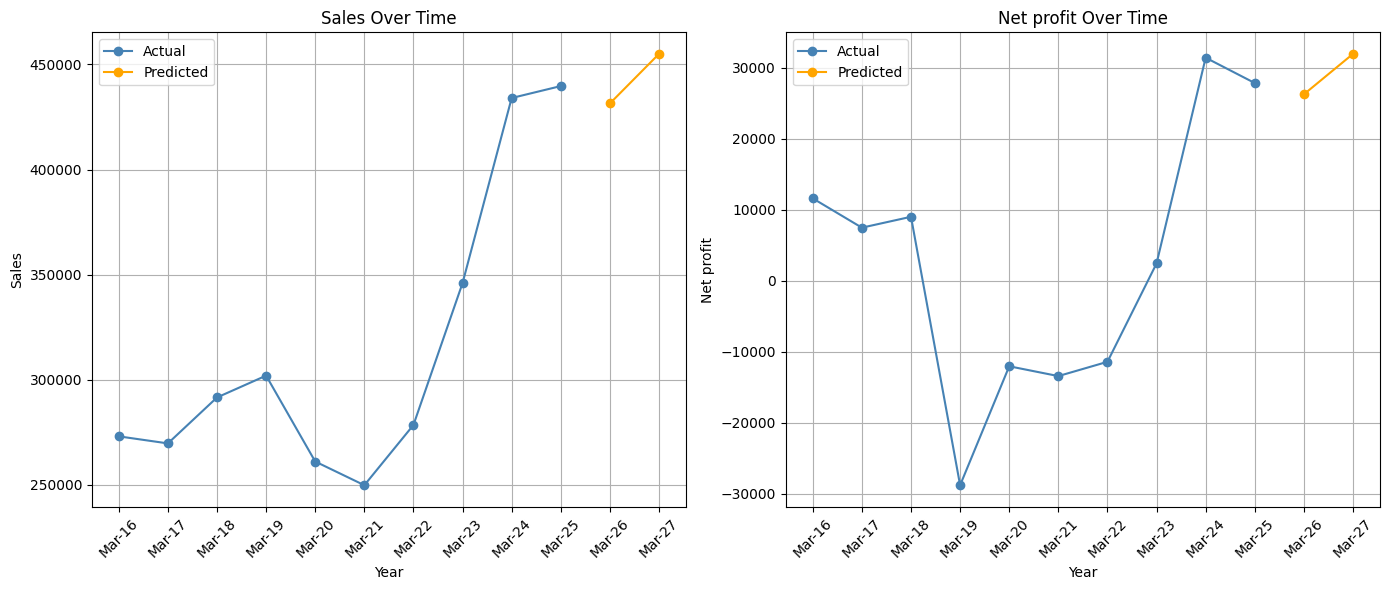

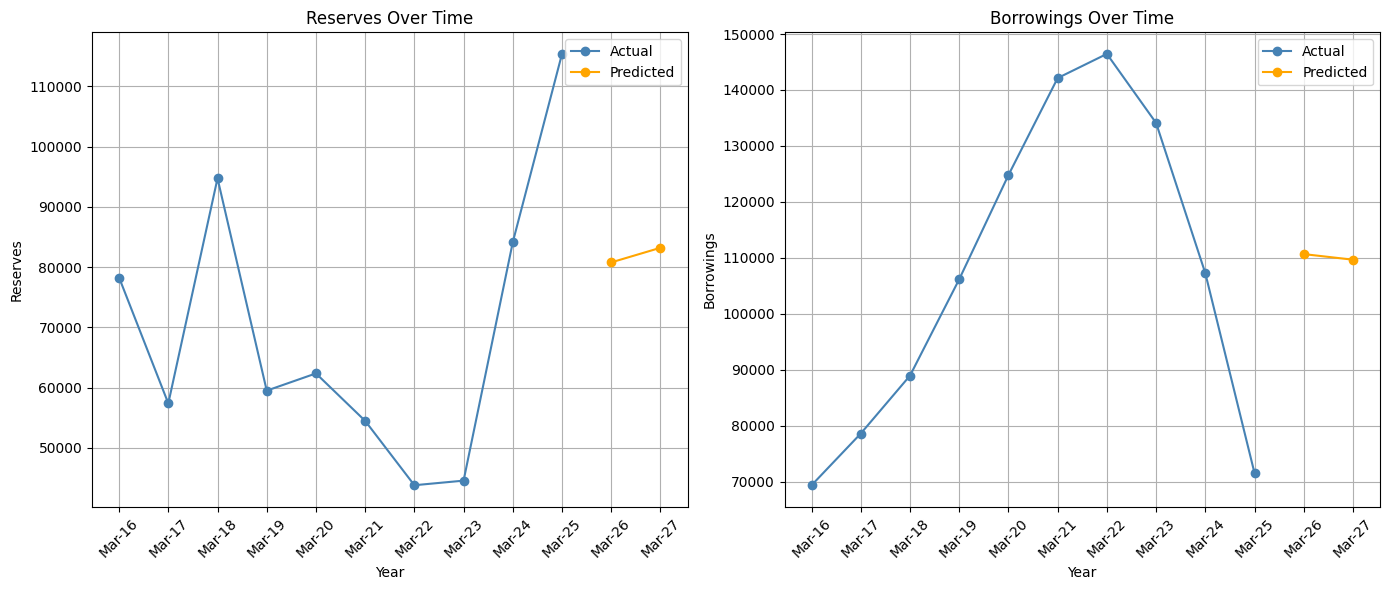

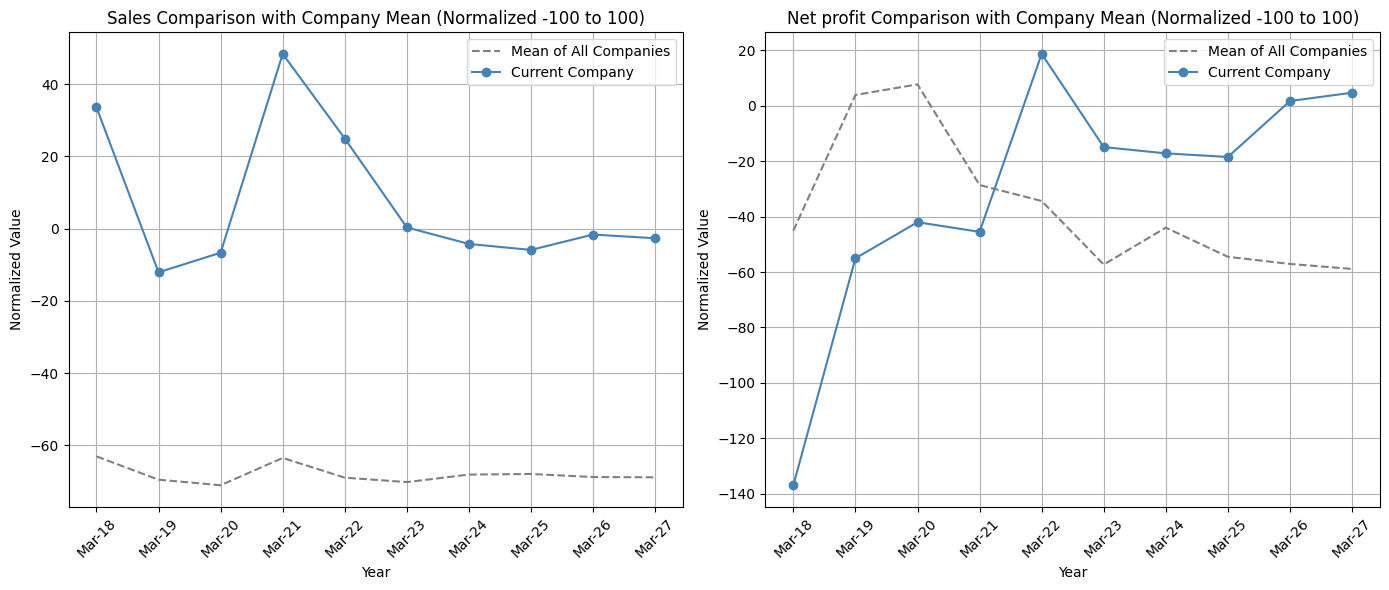

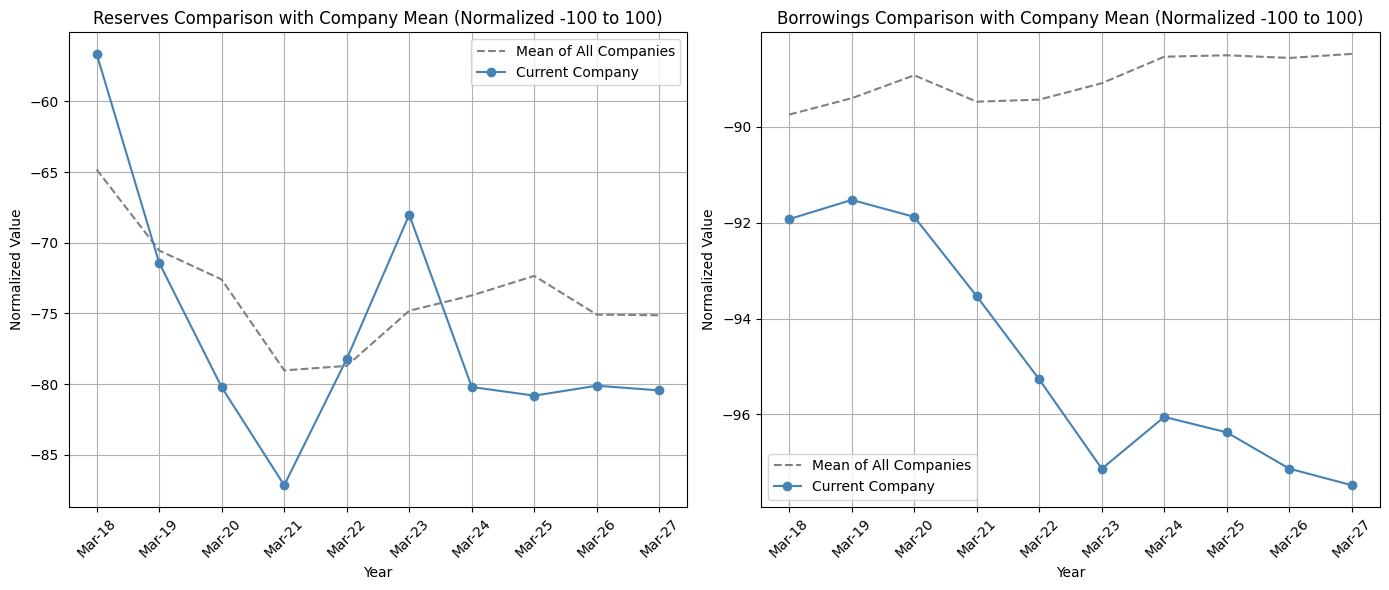

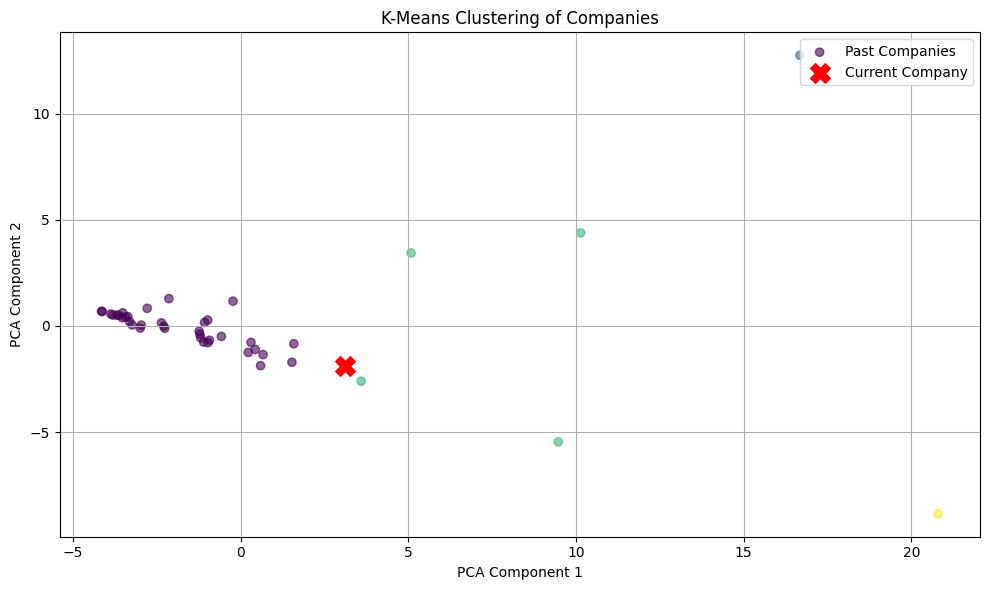

In [16]:
print("\n\ud83d\udcca Visualizing current + predicted company financials...")

# Generate year labels
years = [f"Mar-{16 + i}" for i in range(len(current_features["Sales"]) - 2)]
future = [f"Mar-{len(years) + 16 + i}" for i in range(2)]
all_years = years + future

# Plot each financial feature 2 at a time (actual + predicted)
for i in range(0, len(FEATURES), 2):
    plt.figure(figsize=(14, 6))
    for j in range(2):
        if i + j >= len(FEATURES):
            break
        feature = FEATURES[i + j]
        actual = current_features[feature][:-2]
        predicted = current_features[feature][-2:]

        plt.subplot(1, 2, j + 1)
        plt.plot(years, actual, marker='o', label='Actual', color='steelblue')
        plt.plot(future, predicted, marker='o', label='Predicted', color='orange')
        plt.title(f"{feature} Over Time")
        plt.xlabel("Year")
        plt.ylabel(feature)
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.legend()

    plt.tight_layout()
    plt.show()

# 📊 Mean Comparison Plot (normalized with MinMaxScaler to range -100 to 100)
from sklearn.preprocessing import MinMaxScaler

for i in range(0, len(FEATURES), 2):
    plt.figure(figsize=(14, 6))
    for j in range(2):
        if i + j >= len(FEATURES):
            break
        feature = FEATURES[i + j]
        start_idx = (i + j) * (YEARS_BACK + PREDICT_YEARS)
        end_idx = (i + j + 1) * (YEARS_BACK + PREDICT_YEARS)

        all_values = np.array([vec[start_idx:end_idx] for vec in past_vectors])
        current_values = np.array(vector_current[start_idx:end_idx])

        scaler = MinMaxScaler(feature_range=(-100, 100))
        all_values_scaled = scaler.fit_transform(all_values)
        current_values_scaled = scaler.transform([current_values])[0]
        mean_trend = np.mean(all_values_scaled, axis=0)

        aligned_years = all_years[-len(mean_trend):]

        plt.subplot(1, 2, j + 1)
        plt.plot(aligned_years, mean_trend, label='Mean of All Companies', linestyle='--', color='gray')
        plt.plot(aligned_years, current_values_scaled, label='Current Company', marker='o', color='steelblue')
        plt.title(f"{feature} Comparison with Company Mean (Normalized -100 to 100)")
        plt.xlabel("Year")
        plt.ylabel("Normalized Value")
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.legend()

    plt.tight_layout()
    plt.show()

# 📊 K-Means Clustering Visualization
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)
current_pca = pca.transform(X_current)

kmeans = KMeans(n_clusters=4, random_state=RANDOM_STATE, n_init=10)
kmeans.fit(X_pca)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis', alpha=0.6, label='Past Companies')
plt.scatter(current_pca[0][0], current_pca[0][1], c='red', marker='X', s=200, label='Current Company')
plt.title("K-Means Clustering of Companies")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()